# **Intro VAE**
In this notebook I use a variational autoencoder (VAE) in order to determine the single-cell perturbation effect.



The experimental set-up is as follows:
All data is from Kang dataset.
We generate pesudobulks from the original data, which contains 8 samples and 1 stimulated and one ctrl condition per sample.
We either perturb all cells, a single cell-type, or no cell types. 
This is done when we generate the pseudobulks by sampling from either perturbed or non-perturbed cells within each sample.
This is denoted in the parameter `exp_id`, it can be "all-kang", "mono-kang", "b-kang", "cd4Naive-kang", or "none-kang"
This is like a perturbation that would cause one cell type to change.
We use 2 samples as the "labeled" data (meaning each sample has a ground truth cell-type proportion and it is from the cell-type proportion) and 6 samples with unlabeled data (ground truth proportions are not used in training.)




A lot of the model code was taken from this tutorial: https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb


# **Imports**

In [84]:
# general imports
import warnings
import numpy as np
import scanpy as sc

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from comparator_models import vae
from comparator_models.models import vae4
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [85]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_liver_data/"
bulk_aug_data_path = f"{os.getcwd()}/../../data/bulk_data/liver_sex/"
reference_data_path = f"{os.getcwd()}/../../data/reference_data/"
res_data_path = f"{os.getcwd()}/../../results/single_cell_data/VAE_liver/"

de_genes_path = f"{os.getcwd()}/../../data/single_cell_data/liver_sex/de_pseudobulk_results.pkl"
de_bulk_path = f"{os.getcwd()}/../../data/bulk_data/liver_sex/de_real_bulk_results.pkl"


cibersort_path = f"{os.getcwd()}/../../data/single_cell_data/cibersort_liver/"


cibersort_genes_path = (f"{os.getcwd()}/../../results/single_cell_data/cibersort_liver/" +
                        "CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_refsample.bm.K999.txt")


num_genes = 7000

exp_id = "all-liver"

# Set-up experimental variables

In [86]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8

# number of patients/domains/samples expected
n_tot_samples = 51 # 3 "patients", old / young

# number of drugs (one-hot encoded)
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_tech = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [87]:
bulk_aug_data_path

'/beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../data/bulk_data/liver_sex/'

In [88]:
in_name = "liver_bulk_processed"


# read in the real bulk data
processed_sc_file = f"{bulk_aug_data_path}/{in_name}.h5ad"
adata = sc.read_h5ad(processed_sc_file)


# now get the sc ref training data

# read in male first
sample_order = ['30-M-5']

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_liver_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

# now read in female
sample_order = ['18-F-51']
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_liver_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Test", exp_id)
    pseudobulks_df.columns = gene_df

    X_concat = pd.concat([X_concat, pseudobulks_df])
    Y_concat = pd.concat([Y_concat, prop_df])
    meta_concat = pd.concat([meta_concat, metadata_df])



# read in the bulk data
real_bulk_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# get the bulk metadata formatted
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)


# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(15)]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])


# format the bulk data
real_bulk_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# now we have a new gene_df
gene_df = pd.DataFrame(intersect_genes)
gene_df.columns = ["gene_ids"]
gene_df.set_index(gene_df["gene_ids"])
gene_df = gene_df.gene_ids

# get the bulk metadata formatted
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)

# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(real_bulk_df.shape[0])]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])



30-M-5
18-F-51


<ipython-input-88-87ecae84aa3b>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["isTraining"] = "Train"
<ipython-input-88-87ecae84aa3b>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["cell_prop_type"] = "realistic"
<ipython-input-88-87ecae84aa3b>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

# Define indices and set-up metadata

In [89]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(gene_df, cibersort_genes)



# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -6680)[-6680:] # num_genes # 6679
gene_df = gene_df.iloc[idx_top]


# compare our variable genes with cibersort defined genes

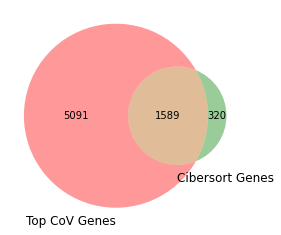

In [90]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [91]:
union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)

7000

# Normalize data

In [92]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


X_vae = X_full[idx_train,]
label_vae = label_full[idx_train,]
bulk_vae = bulk_full[idx_train,]
drug_vae = drug_full[idx_train,]
y_vae = Y_full.iloc[idx_train,]




# Plot all data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3649 samples in 0.042s...
[t-SNE] Computed neighbors for 3649 samples in 1.582s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3649
[t-SNE] Computed conditional probabilities for sample 2000 / 3649
[t-SNE] Computed conditional probabilities for sample 3000 / 3649
[t-SNE] Computed conditional probabilities for sample 3649 / 3649
[t-SNE] Mean sigma: 1.161060
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.328995
[t-SNE] KL divergence after 500 iterations: 0.965905
(3649, 2)
(3649, 2)


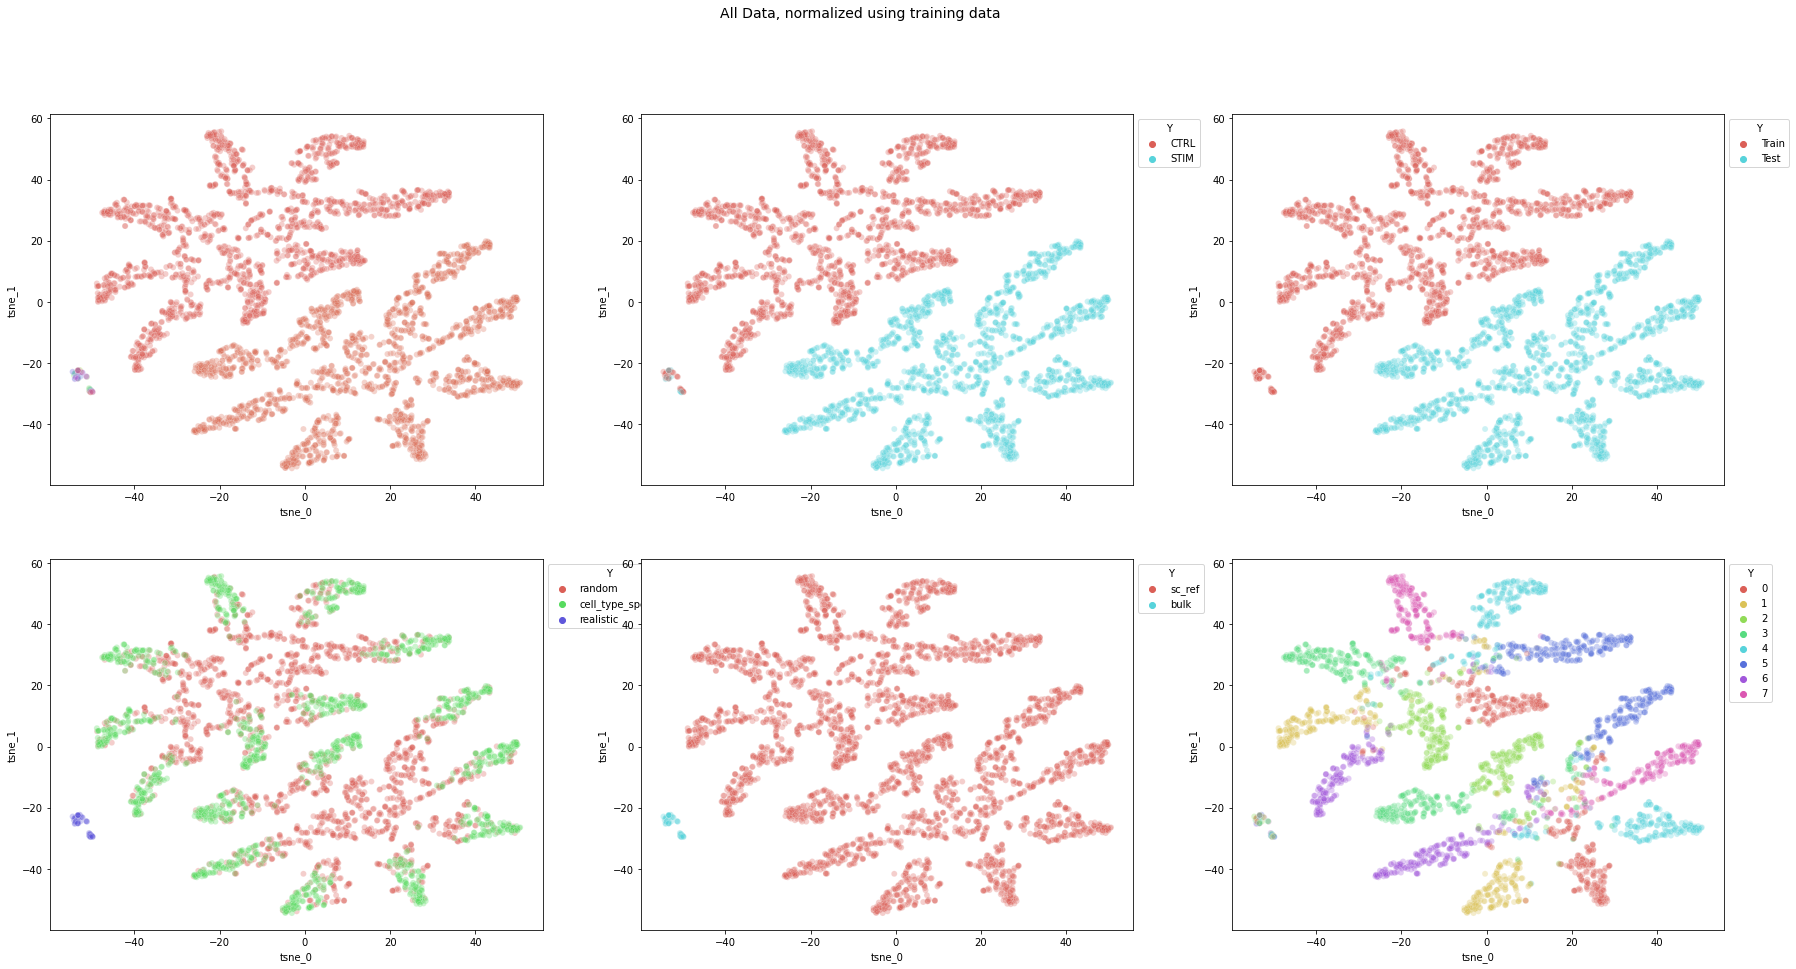

In [93]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Run VAE**

## Hyperparameter Search

We are going to search over 2 parameters: 

1.  the beta_kl (0.001, 0.01, 1, 10)
2.  the number of epochs  (50, 100)

In [95]:
from importlib import reload  # Python 3.4+
reload(vae)
reload(vae4)
reload(sc_preprocess)
reload(vp)


<module 'buddi.plotting.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../buddi/plotting/validation_plotting.py'>

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_decoder/assets


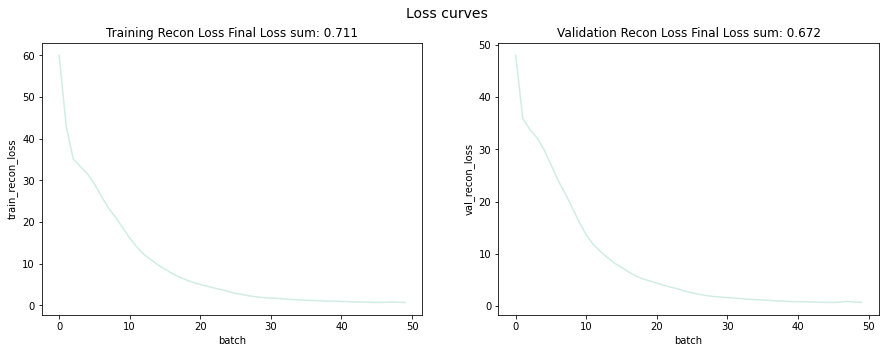

In [96]:
curr_n_epoch=50
curr_kl = 0.001
curr_n_z = 10
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_decoder/assets


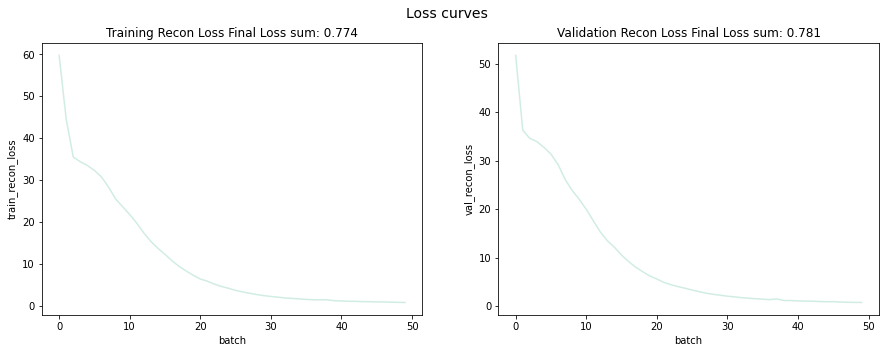

In [97]:
curr_n_epoch=50
curr_kl = 0.001
curr_n_z = 50
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_decoder/assets


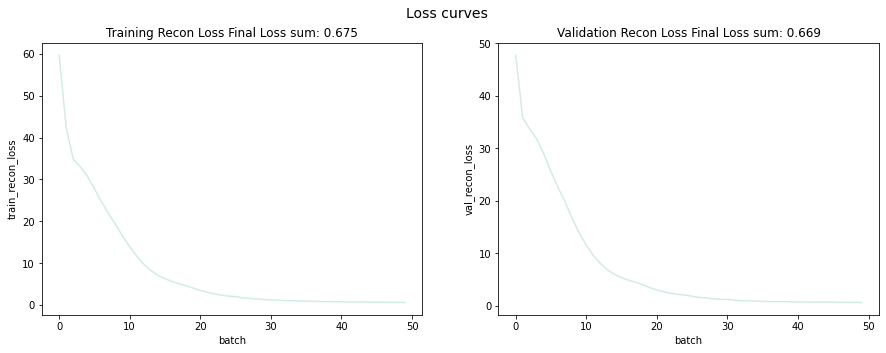

In [98]:
curr_n_epoch=50
curr_kl = 0.001
curr_n_z = 100
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_decoder/assets


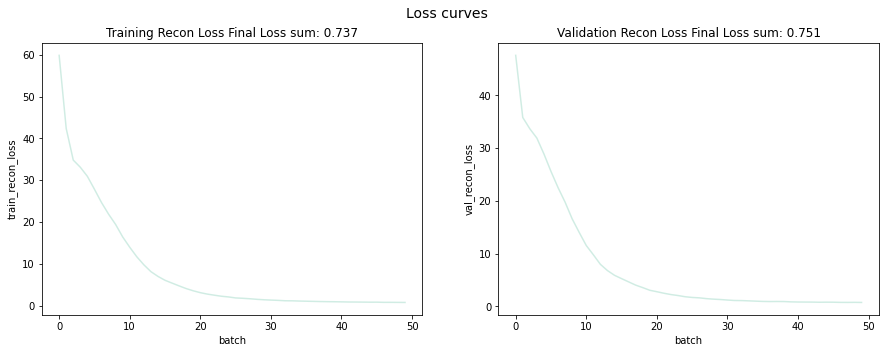

In [99]:
curr_n_epoch=50
curr_kl = 0.001
curr_n_z = 200
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.001_all-liver_decoder/assets


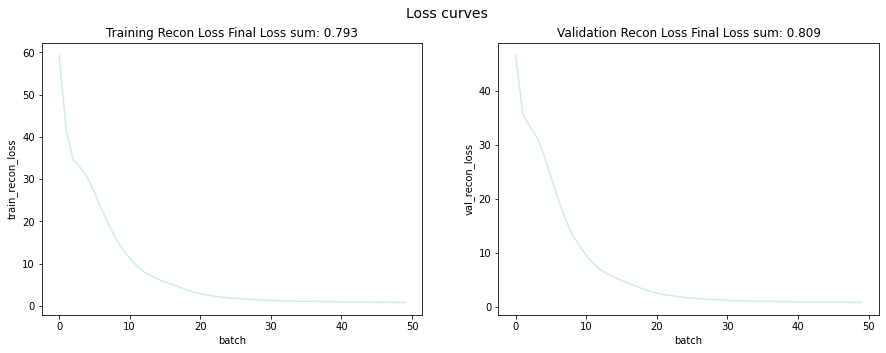

In [100]:
curr_n_epoch=50
curr_kl = 0.001
curr_n_z = 300
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_decoder/assets


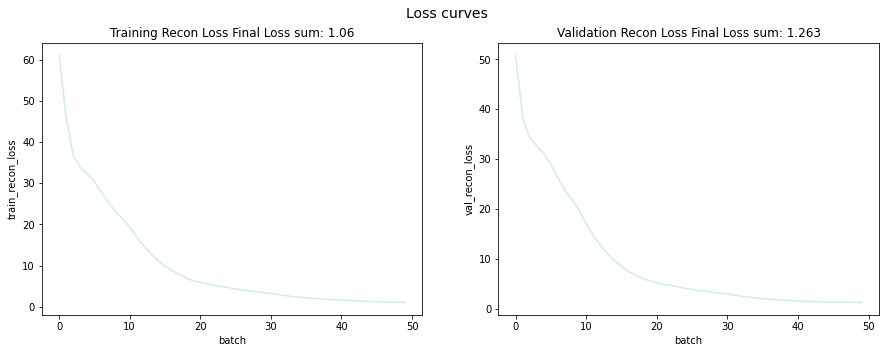

In [101]:
curr_n_epoch=50
curr_kl = 0.01
curr_n_z = 10
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_decoder/assets


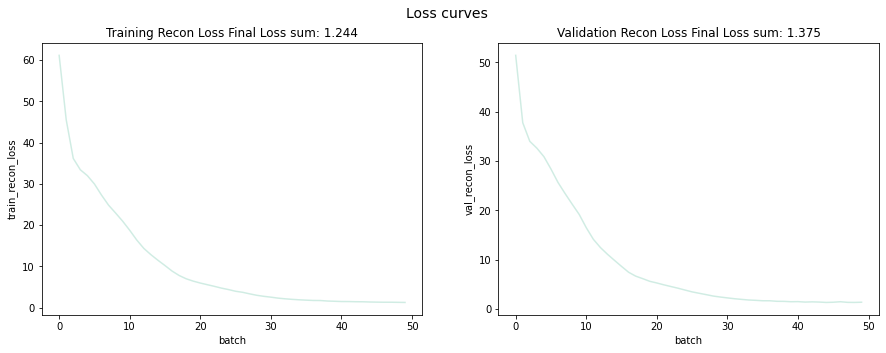

In [102]:
curr_n_epoch=50
curr_kl = 0.01
curr_n_z = 50
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_decoder/assets


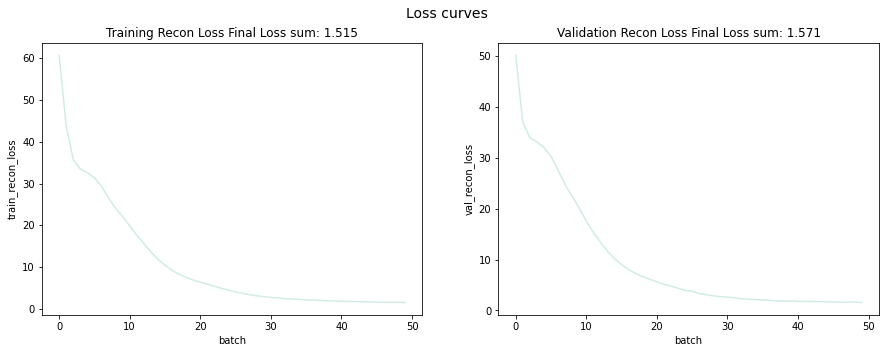

In [103]:
curr_n_epoch=50
curr_kl = 0.01
curr_n_z = 100
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_decoder/assets


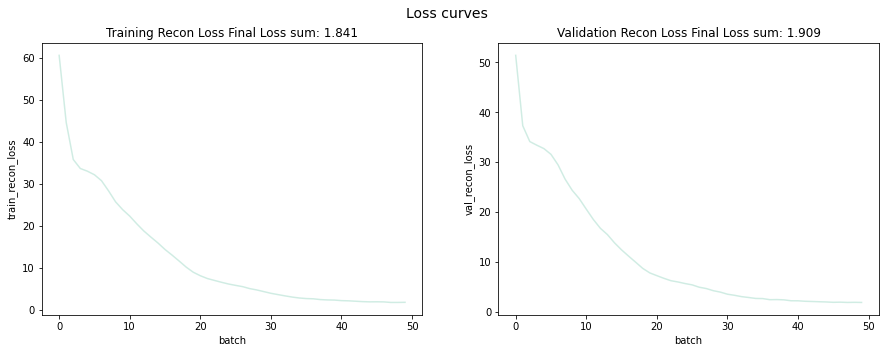

In [104]:
curr_n_epoch=50
curr_kl = 0.01
curr_n_z = 200
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_0.01_all-liver_decoder/assets


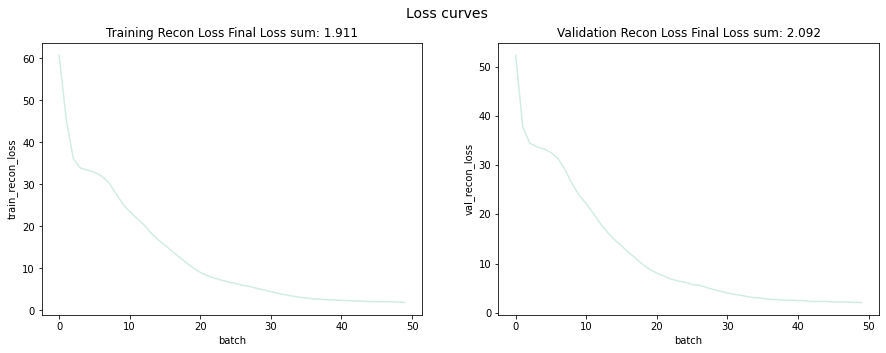

In [105]:
curr_n_epoch=50
curr_kl = 0.01
curr_n_z = 300
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_decoder/assets


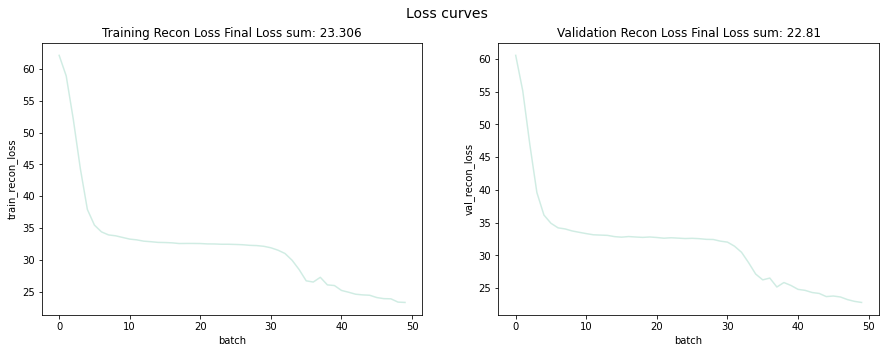

In [106]:
curr_n_epoch=50
curr_kl = 1
curr_n_z = 10
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_decoder/assets


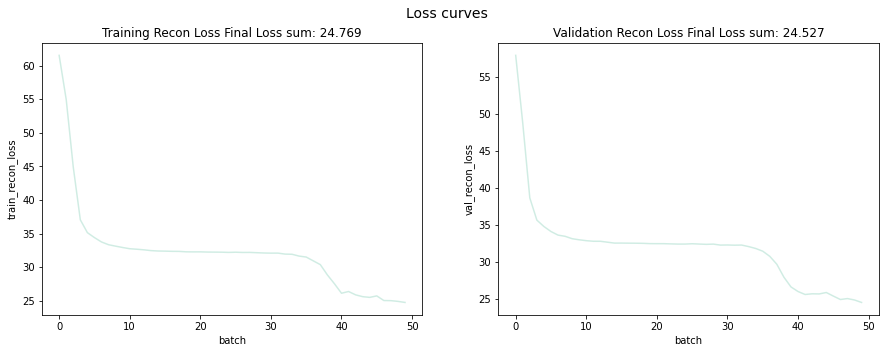

In [107]:
curr_n_epoch=50
curr_kl = 1
curr_n_z = 50
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_decoder/assets


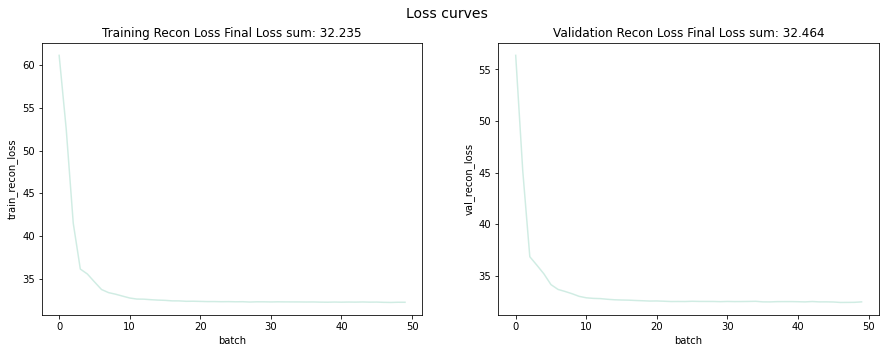

In [108]:
curr_n_epoch=50
curr_kl = 1
curr_n_z = 100
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_decoder/assets


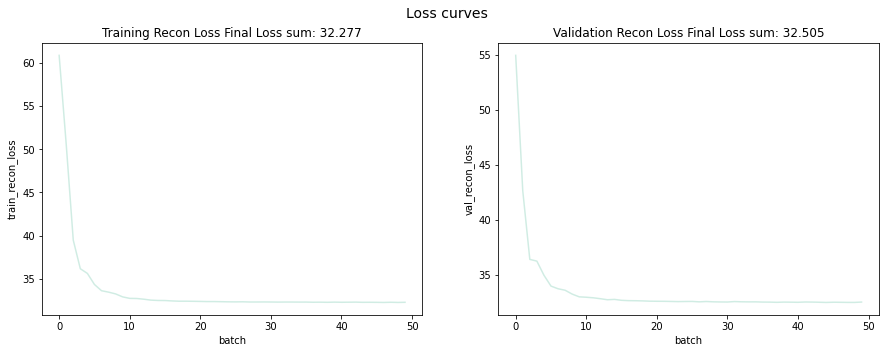

In [109]:
curr_n_epoch=50
curr_kl = 1
curr_n_z = 200
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_1_all-liver_decoder/assets


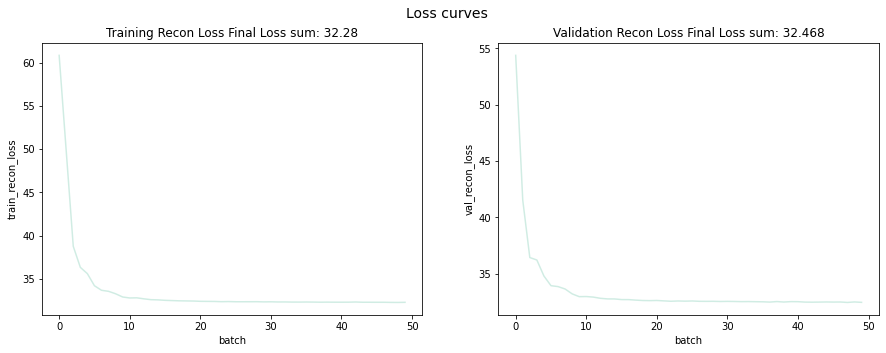

In [110]:
curr_n_epoch=50
curr_kl = 1
curr_n_z = 300
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_decoder/assets


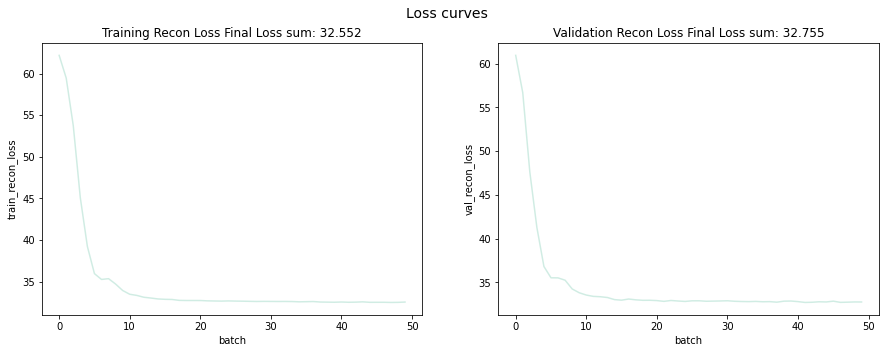

In [111]:
curr_n_epoch=50
curr_kl = 10
curr_n_z = 10
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_decoder/assets


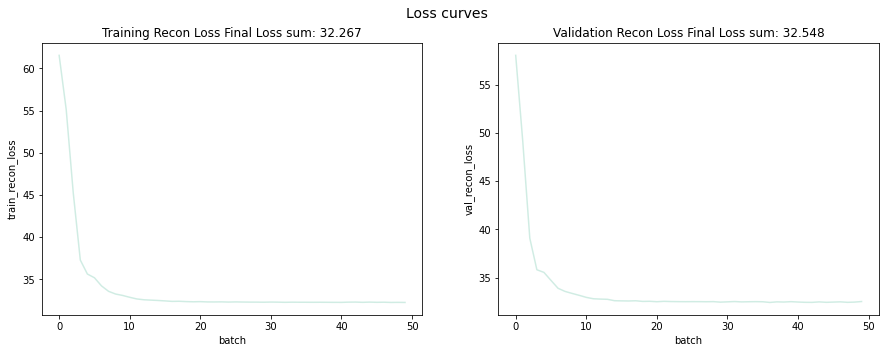

In [112]:
curr_n_epoch=50
curr_kl = 10
curr_n_z = 50
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_decoder/assets


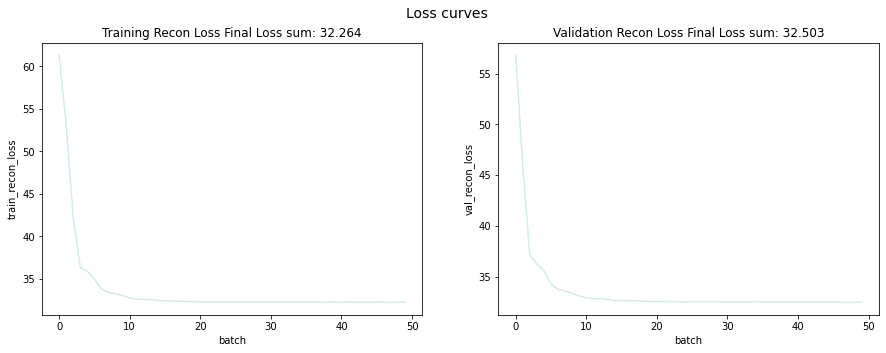

In [113]:
curr_n_epoch=50
curr_kl = 10
curr_n_z = 100
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_decoder/assets


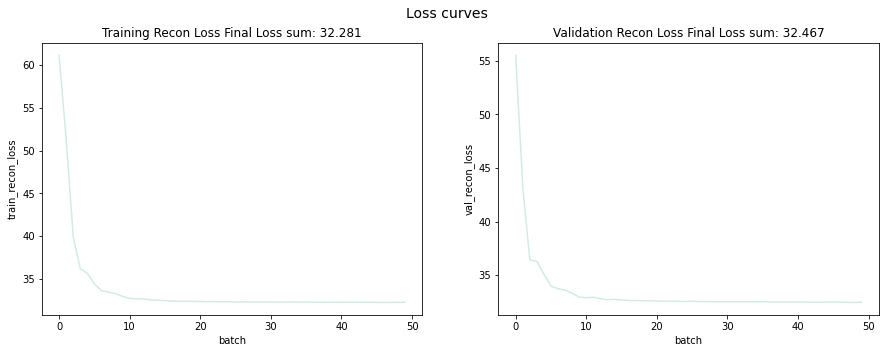

In [114]:
curr_n_epoch=50
curr_kl = 10
curr_n_z = 200
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//50_10_all-liver_decoder/assets


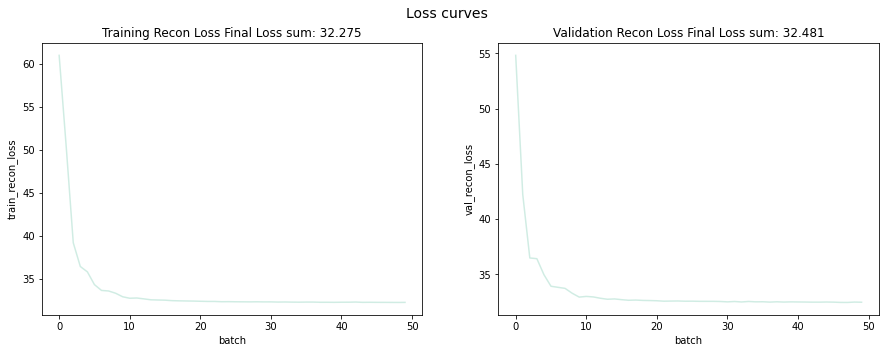

In [115]:
curr_n_epoch=50
curr_kl = 10
curr_n_z = 300
params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl, n_z=curr_n_z)

curr_exp_id = f"{curr_n_epoch}_{curr_kl}_{exp_id}"
res = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

# **Results**

Looking at all the results, we see that beta_kl = 0.001 performs the best overall. We will go forward with this hyperparameters and run them three times to get 3 different trained models that we can use for downstream validation.

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model1_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model1_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model1_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model1_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model1_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model1_all-liver_decoder/assets
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model2_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model2_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model2_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model2_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model2_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model2_all-liver_decoder/assets
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model3_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model3_all-liver_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model3_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model3_all-liver_encoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model3_all-liver_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../results/single_cell_data/VAE_liver//model3_all-liver_decoder/assets


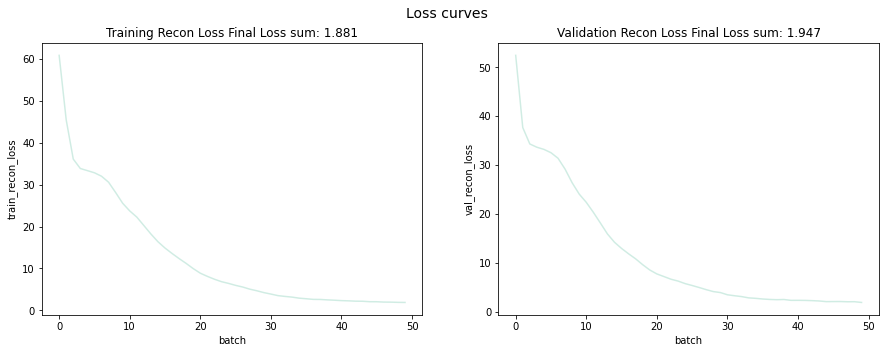

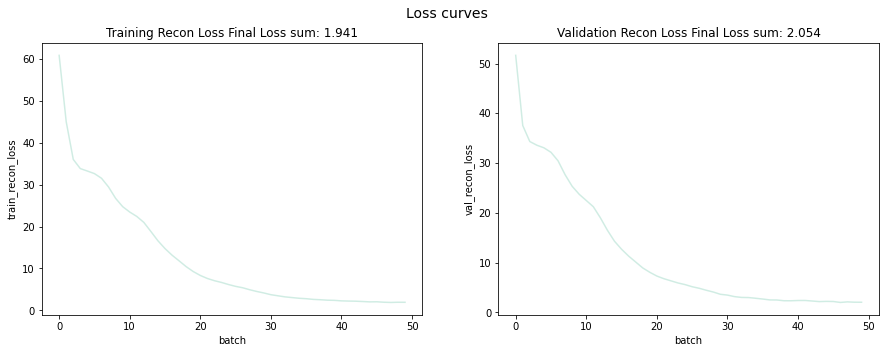

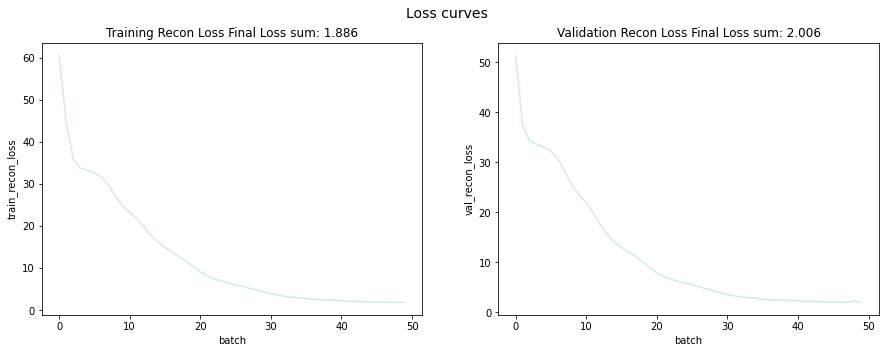

In [214]:
curr_n_epoch=50
curr_kl = 0.01
curr_n_z = 10

params = vae.VAETrainParameters(n_epoch=curr_n_epoch, beta_kl=curr_kl)

## model 1
curr_exp_id = f"model1_{exp_id}"
res1 = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)


## model 2
curr_exp_id = f"model2_{exp_id}"
res2 = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)

## model 3
curr_exp_id = f"model3_{exp_id}"
res3 = vae.train_vae(res_data_path, curr_exp_id, use_vae4=True, 
            X_vae=X_vae,
            params=params)            

# visualize reconstructions

### subset data

In [215]:
# take all training data
recon_idx = meta_df.isTraining == "Train"
recon_idx = np.where(recon_idx)[0]
recon_idx = np.random.choice(recon_idx, 5000, replace=True)

# subset our data

meta_temp = meta_df.iloc[recon_idx]

X_temp = np.copy(X_full[recon_idx])

Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)


label_temp = np.copy(label_full[recon_idx])
label_num = np.copy(Label_full[recon_idx])

perturb_temp = drug_full[recon_idx]

bulk_temp = bulk_full[recon_idx]




### plot data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)


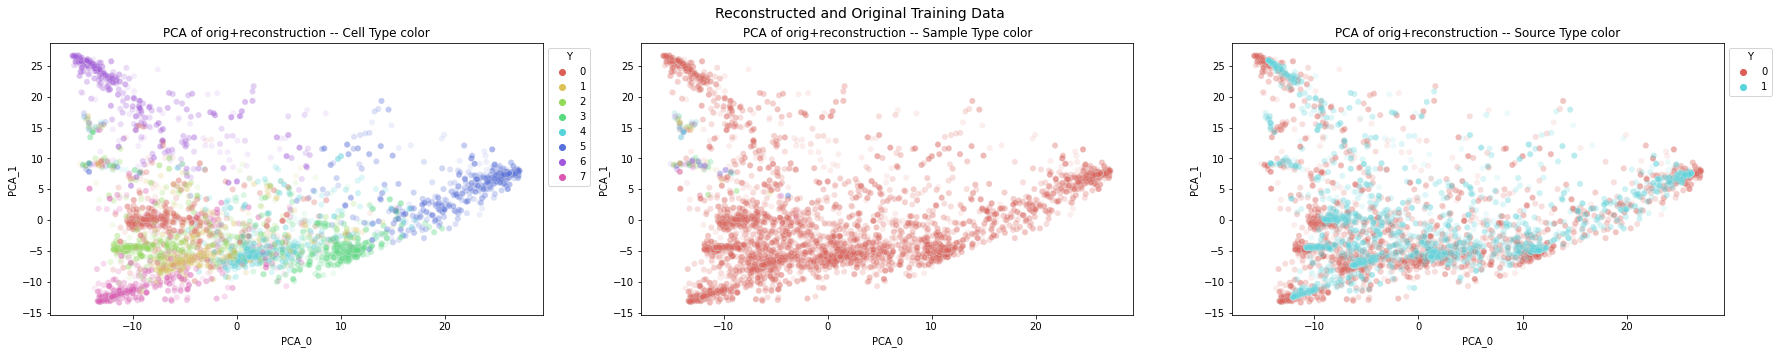

In [216]:
res1_recon_plot = vae.plot_reconstruction_vae(res1.encoder, res1.decoder,
        X_temp, Y_temp, label_num,
        batch_size=500)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)


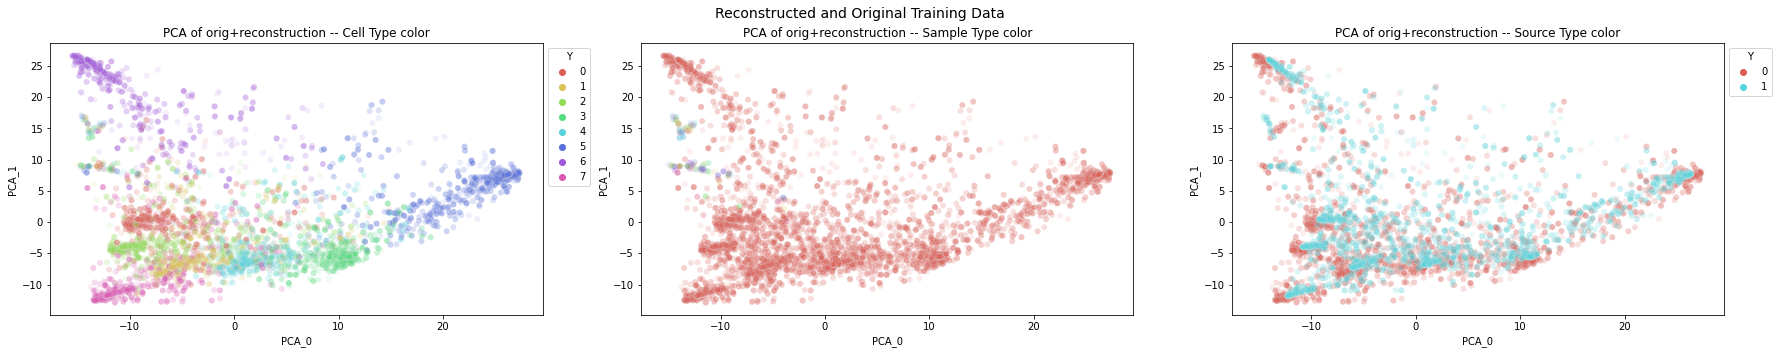

In [217]:
res2_recon_plot = vae.plot_reconstruction_vae(res2.encoder, res2.decoder,
        X_temp, Y_temp, label_num,
        batch_size=500)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)


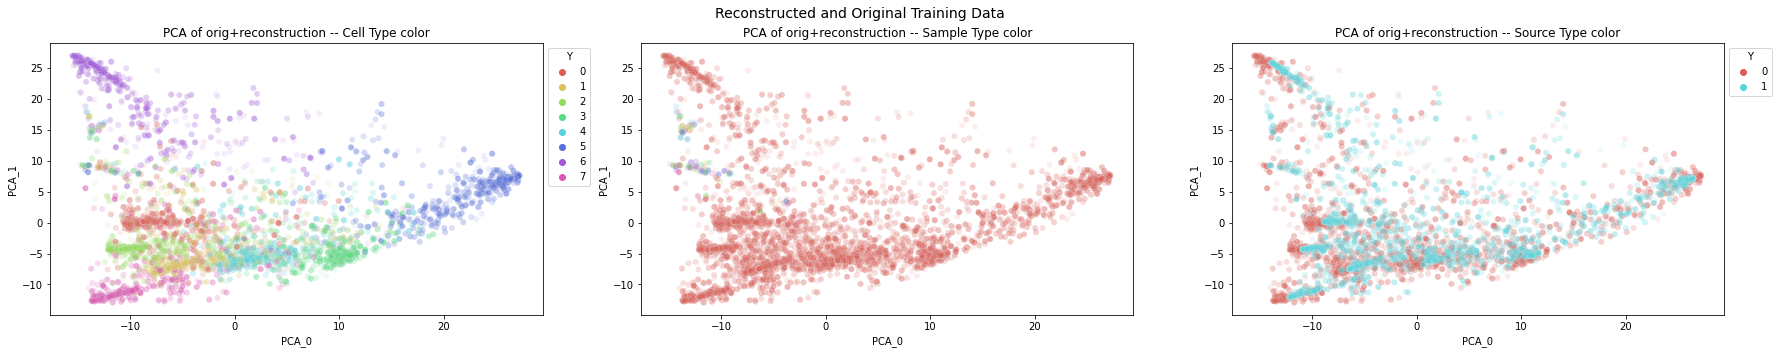

In [218]:
res3_recon_plot = vae.plot_reconstruction_vae(res3.encoder, res3.decoder,
        X_temp, Y_temp, label_num,
        batch_size=500)

# Do latent space projections

### drug perturbation

In [219]:
res1_meta_df, res1_decoded_0_0, res1_decoded_0_1, top_genes = vae.calc_VAE_perturbation(X_full, Y_full, meta_df, 
                                                                        res1.encoder, res1.decoder, 
                                                                        scaler, batch_size=500, 
                                                                        genes_ordered=union_genes, 
                                                                        top_lim=100)

/beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../comparator_models/vae.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_meta_df["isTraining"] = "Test"


(1000, 2)
(1000, 2)


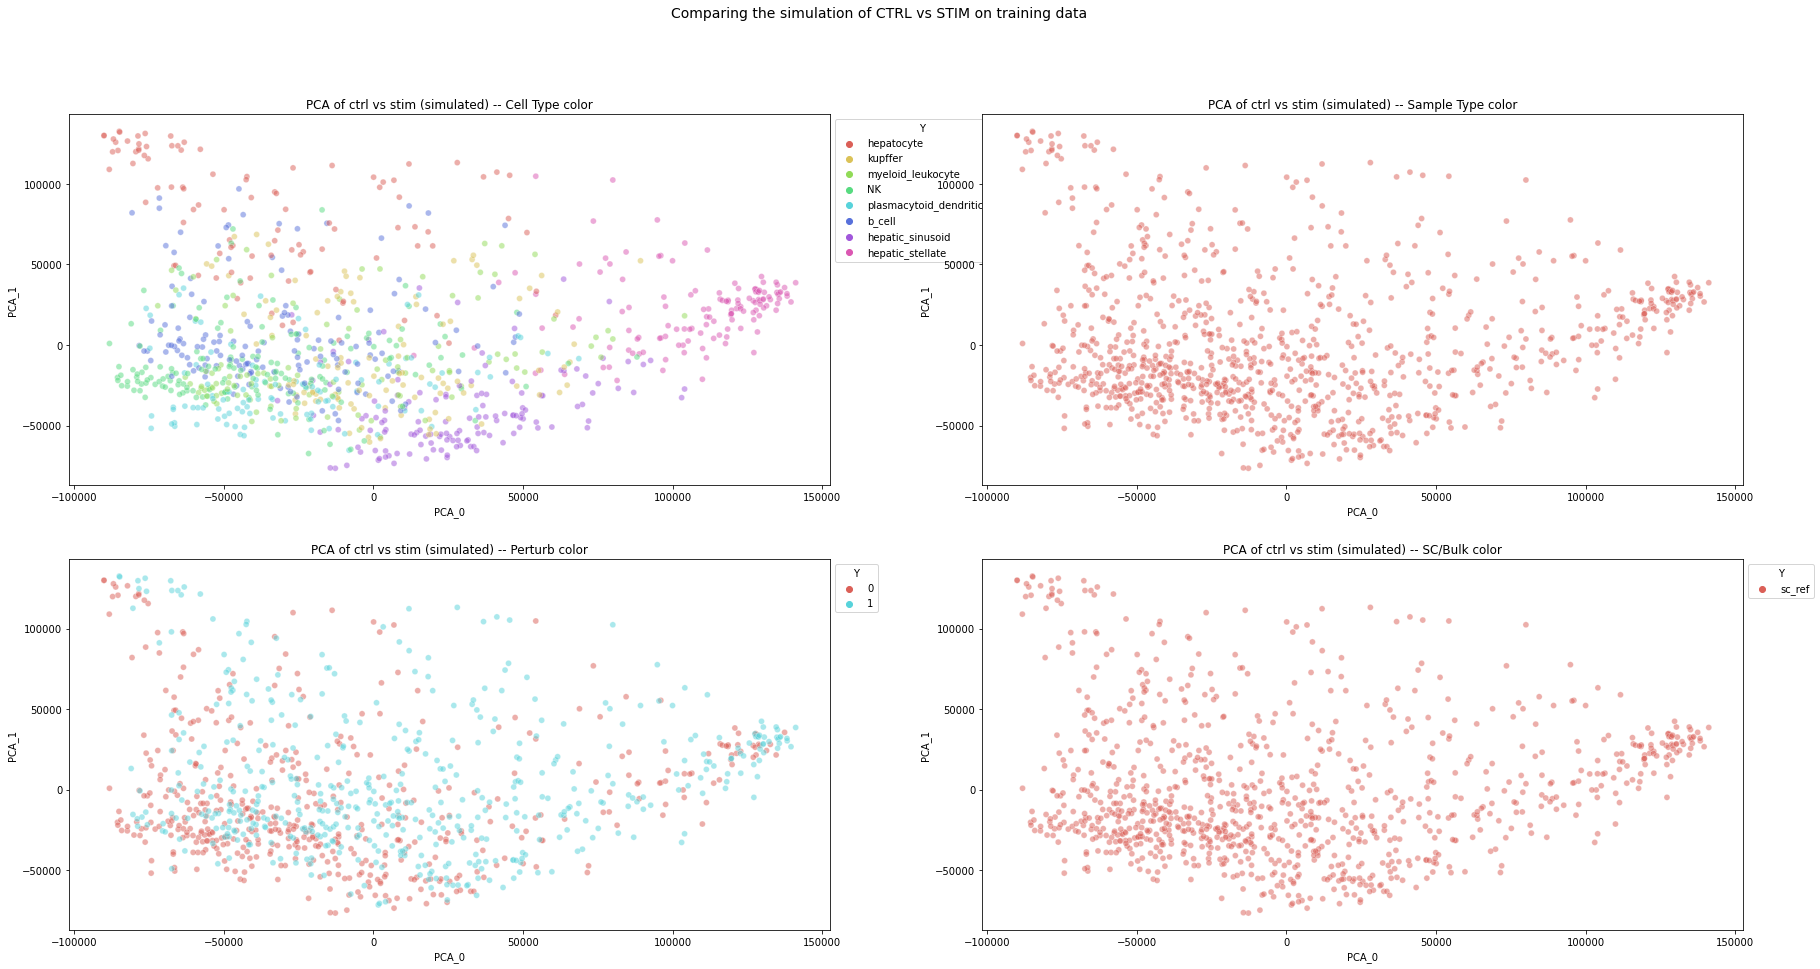

In [220]:
# make duplicated
X_dup = np.vstack([res1_decoded_0_0, res1_decoded_0_1])


Y_dup = np.append(res1_meta_df.Y_max, res1_meta_df.Y_max)


label_dup = np.append(res1_meta_df.sample_id, res1_meta_df.sample_id)

n_row_temp = res1_meta_df.shape[0]
perturb_dup = np.asarray(np.append([0]*n_row_temp, [1]*n_row_temp))
source_dup = np.append(res1_meta_df.samp_type, res1_meta_df.samp_type)

fig, axs = plt.subplots(2, 2, figsize=(30,15))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0,0], title="PCA of ctrl vs stim (simulated) -- Cell Type color", alpha=0.5)
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[0,1], title="PCA of ctrl vs stim (simulated) -- Sample Type color", alpha=0.5)
vp.plot_pca(plot_df, color_vec=perturb_dup, ax=axs[1,0], title="PCA of ctrl vs stim (simulated) -- Perturb color", alpha=0.5)
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[1,1], title="PCA of ctrl vs stim (simulated) -- SC/Bulk color", alpha=0.5)



fig.suptitle("Comparing the simulation of CTRL vs STIM on training data", fontsize=14)
axs[0,1].legend([],[], frameon=False)

fig.show()

In [221]:
res1_meta_df, res1_decoded_0_0, res1_decoded_0_1, res1_top_genes = vae.calc_VAE_perturbation(X_full, Y_full, meta_df, 
                                                                        res1.encoder, res1.decoder, 
                                                                        scaler, batch_size=500, 
                                                                        genes_ordered=union_genes, 
                                                                        top_lim=100)

res2_meta_df, res2_decoded_0_0, res2_decoded_0_1, res2_top_genes = vae.calc_VAE_perturbation(X_full, Y_full, meta_df, 
                                                                        res2.encoder, res2.decoder, 
                                                                        scaler, batch_size=500, 
                                                                        genes_ordered=union_genes, 
                                                                        top_lim=100)

res3_meta_df, res3_decoded_0_0, res3_decoded_0_1, res3_top_genes = vae.calc_VAE_perturbation(X_full, Y_full, meta_df, 
                                                                        res2.encoder, res2.decoder, 
                                                                        scaler, batch_size=500, 
                                                                        genes_ordered=union_genes, 
                                                                        top_lim=100)


/beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../comparator_models/vae.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_meta_df["isTraining"] = "Test"
/beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../comparator_models/vae.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_meta_df["isTraining"] = "Test"
/beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../comparator

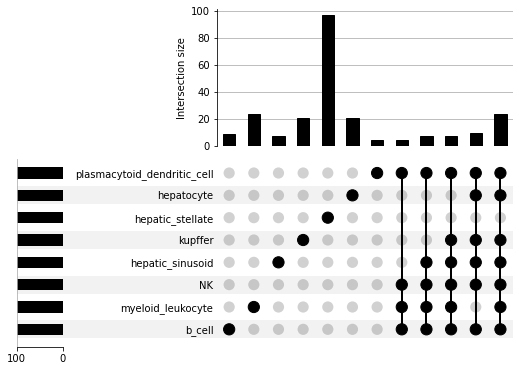

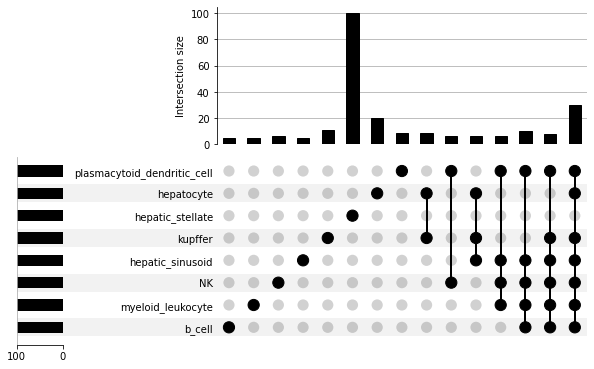

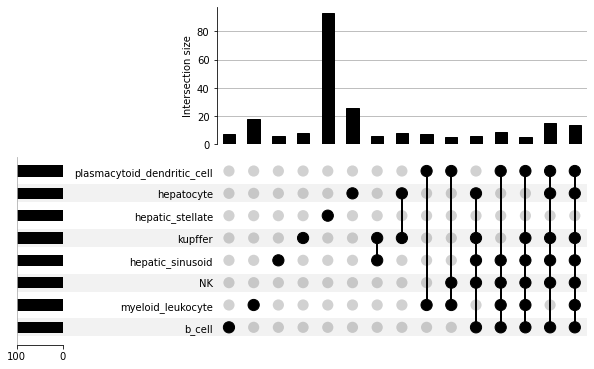

In [222]:
# identify how cell-type specific the DE genes are
cell_diff = from_contents(res1_top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()

cell_diff = from_contents(res2_top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()

cell_diff = from_contents(res3_top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()


### load the single-nucleus DE results from XX publication

In [223]:
from gene_lists import load_genelists

union_genes_cap, Pub_DE, Pub_DE_immune, Pub_DE_hepatic, Pub_DE_kupffer, Pub_DE_hsc = load_genelists(union_genes)

### load bulk DE results

In [224]:
de_bulk = pickle.load(open( de_bulk_path, "rb" ))
de_bulk.index = [x.upper() for x in de_bulk.index] 
de_bulk = de_bulk.iloc[np.where(de_bulk.padj < 1)[0]]
intersect_bulk = np.intersect1d(de_bulk.index.to_list(), union_genes_cap)

bulk_sig_df = pd.DataFrame(union_genes_cap, index=union_genes_cap)
bulk_sig_df["padj"] = 1
padj_val = de_bulk.padj[intersect_bulk]
bulk_sig_df.padj.loc[intersect_bulk] = padj_val

bulk_sig_df["log10padj"] = -1*np.log10(bulk_sig_df.padj)

bulk_sig_df["log2FC"] = 1
fc_val = de_bulk.log2FoldChange[intersect_bulk]
bulk_sig_df.log2FC.loc[intersect_bulk] = np.abs(fc_val)

bulk_sig_df

<ipython-input-224-1b0febddcbf6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_sig_df.padj.loc[intersect_bulk] = padj_val
<ipython-input-224-1b0febddcbf6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_sig_df.log2FC.loc[intersect_bulk] = np.abs(fc_val)


0  padj  log10padj  log2FC
0610005C13RIK  0610005C13RIK   1.0       -0.0     1.0
0610009B22RIK  0610009B22RIK   1.0       -0.0     1.0
0610010F05RIK  0610010F05RIK   1.0       -0.0     1.0
0610012G03RIK  0610012G03RIK   1.0       -0.0     1.0
0610031O16RIK  0610031O16RIK   1.0       -0.0     1.0
...                      ...   ...        ...     ...
ZXDB                    ZXDB   1.0       -0.0     1.0
ZYG11B                ZYG11B   1.0       -0.0     1.0
ZYX                      ZYX   1.0       -0.0     1.0
ZZEF1                  ZZEF1   1.0       -0.0     1.0
A                          A   1.0       -0.0     1.0

[7000 rows x 4 columns]

### load single-cell DE genes result

In [225]:
de_genes = pickle.load(open( de_genes_path, "rb" ))
de_genes

{'hepatocyte': ['Rbp4',
  'Rpl37',
  'Serpina1d',
  'Apoc1',
  'Serpina1b',
  'Itih2',
  'Hmgcs2',
  'Rpl36',
  'Mgst1',
  'Gnmt',
  'Rplp1',
  'Rps15',
  'Rpl38',
  'Ttr',
  'Etfa',
  'Ebpl',
  'Pah',
  'Amacr',
  'Ndufa3',
  'Rps8',
  'Cox4i1',
  'Aldh2',
  'Atf5',
  'Rps25',
  'Hamp',
  'Fau',
  'Serpina1a',
  'Rps27a',
  'Rps14',
  'Acaa1b',
  'Ldha',
  'Mup3',
  'Atp5e',
  'Ftcd',
  'Prdx1',
  'Ndufa13',
  'Rpl35',
  'Rpl28',
  'Tst',
  'Atp5g3',
  'Fah',
  'Rpl8',
  'Rpl13a',
  'Rps3a',
  'Slc25a3',
  'Uqcrq',
  'Fbp1',
  'Rpl14',
  'Ttc36',
  'Atp5b',
  'Hebp1',
  'Rps12',
  'Otc',
  'Eef1a1',
  'Rps24',
  'Gchfr',
  'Ccbl2',
  'Ftl1',
  'Atp5a1',
  'Igfbp4',
  'Rps18',
  'Hspd1',
  'Ndufv3',
  'Ran',
  'Gstt1',
  'Rps4x',
  'Dpyd',
  'Etfb',
  'Serpina1c',
  'Sod1',
  'Rpl13',
  'Gstz1',
  'Hsd11b1',
  'Rpl23',
  'Chchd2',
  'Hgd',
  'Ndufc2',
  'Acad11',
  'Ndufa6',
  'Got2',
  'Uqcr11',
  'Rpl7a',
  'Ctsh',
  'Pgls',
  'Spr',
  'Tmem93',
  'Dak',
  'Rpl9',
  'Khk',
  'Hmgcs1'

### get PR curves and tables

In [226]:
# number of genes from our differential expression analysis
# to be considered top DE
min_overlap = 50

In [227]:
from importlib import reload  # Python 3.4+
reload(vae)
reload(vae.vae4)
reload(sc_preprocess)
reload(vp)


<module 'buddi.plotting.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/liver_analysis/sex_prediction_comparators/../../buddi/plotting/validation_plotting.py'>

hepatocyte
hepatic_sinusoid
kupffer
hepatic_stellate
NK
b_cell


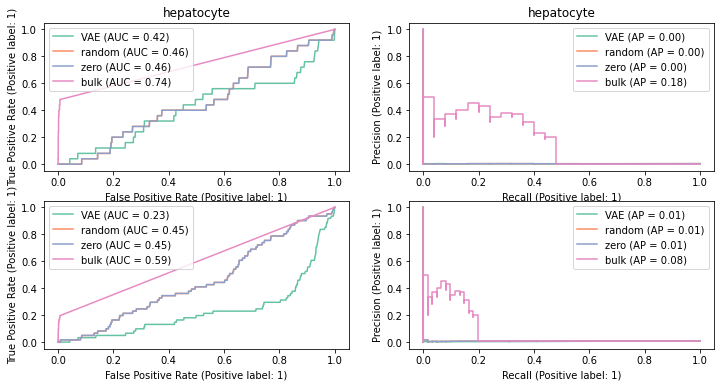

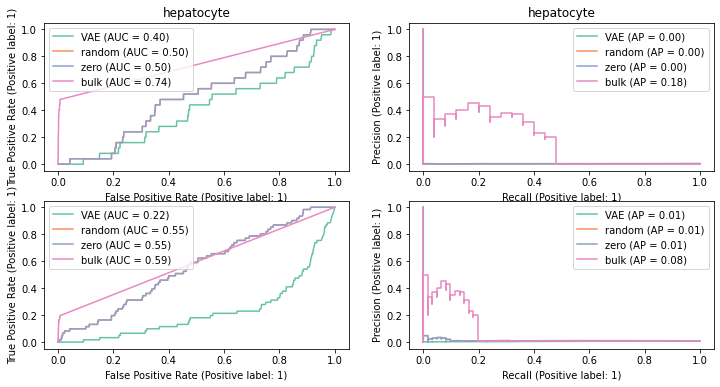

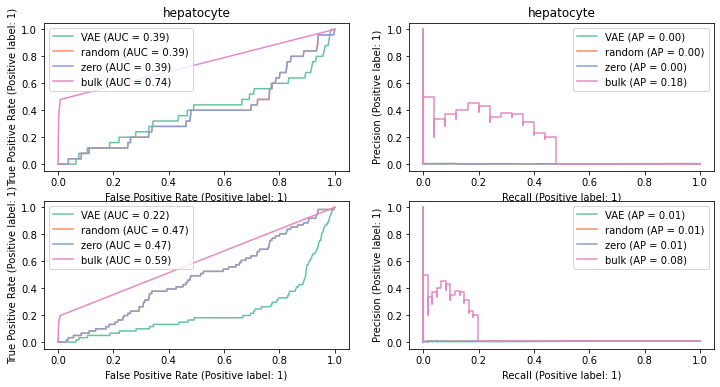

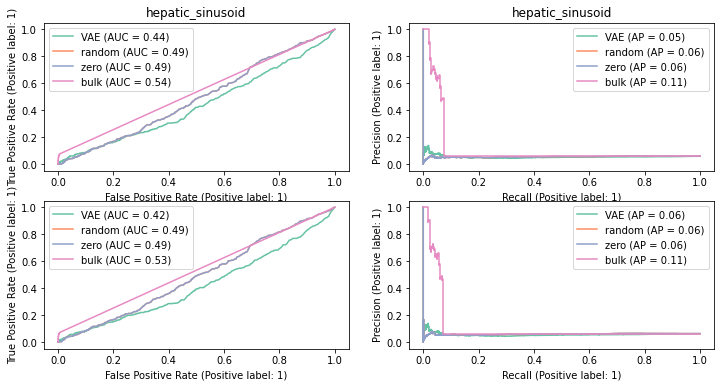

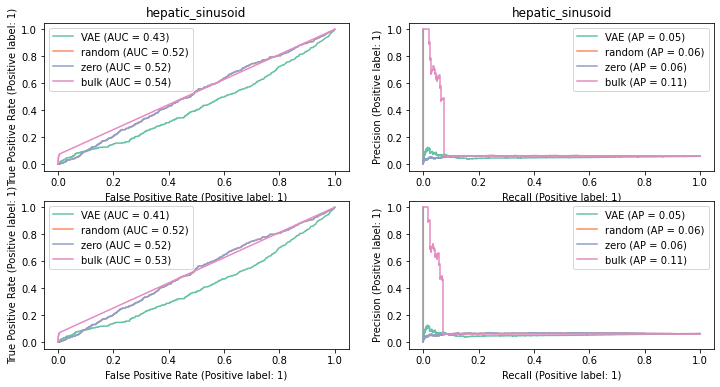

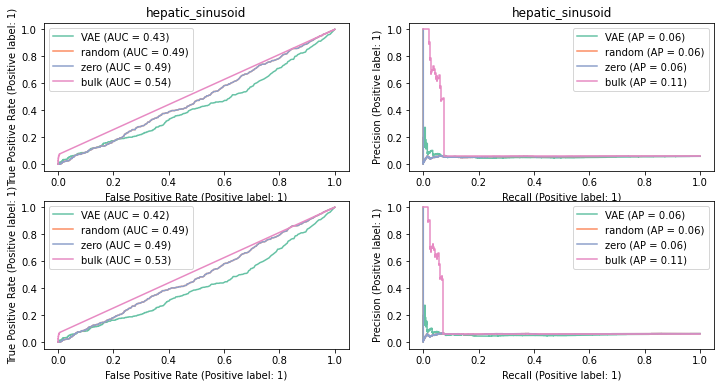

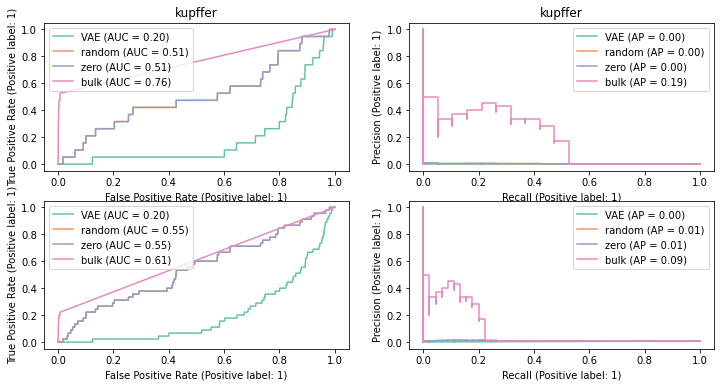

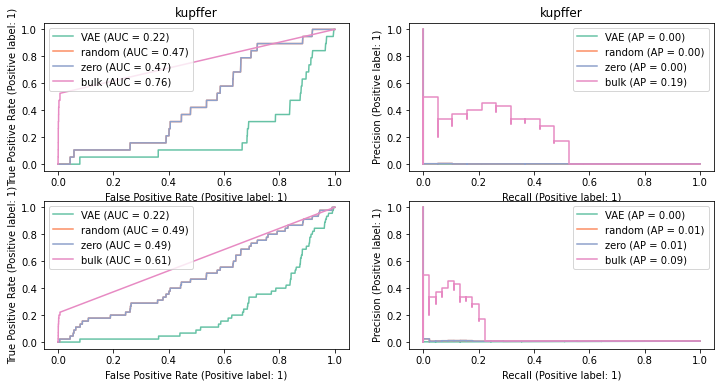

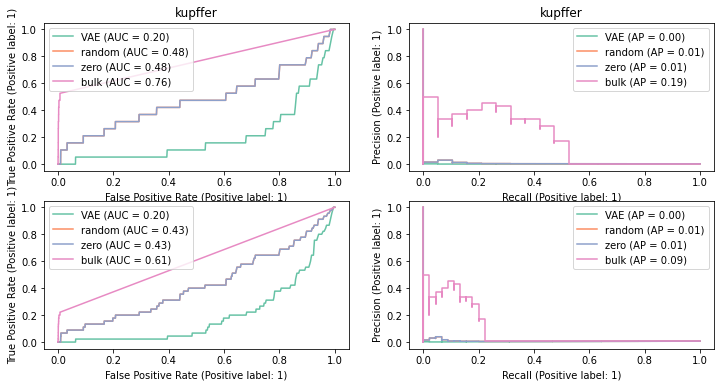

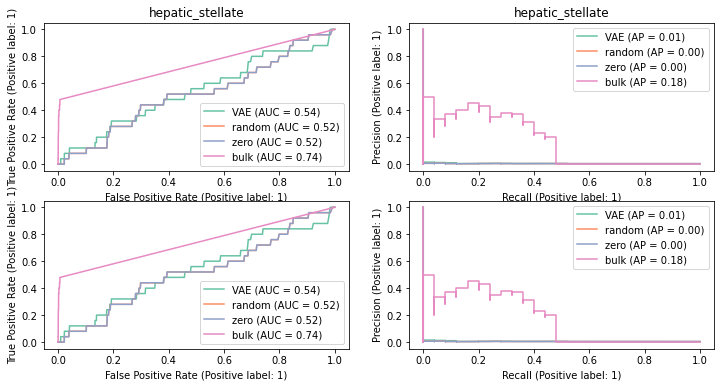

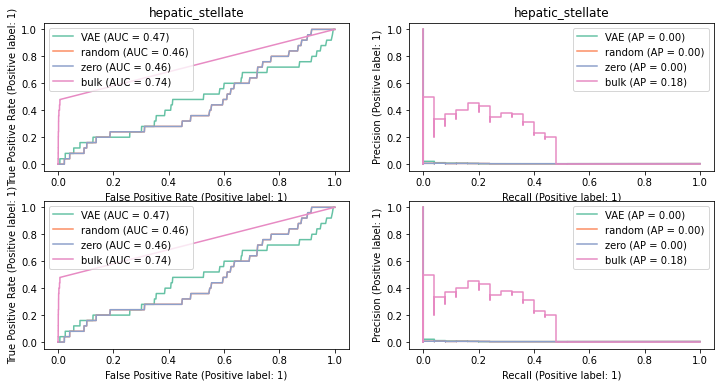

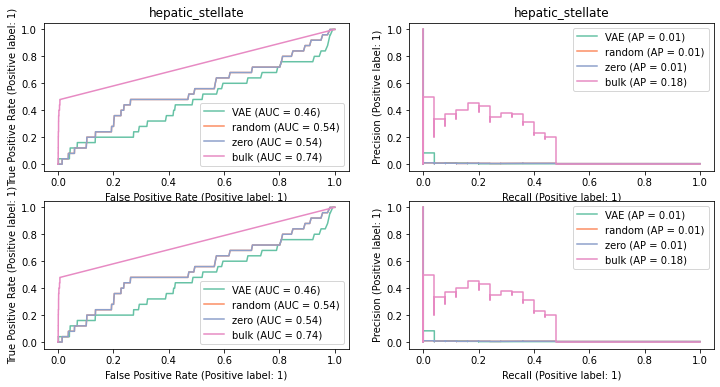

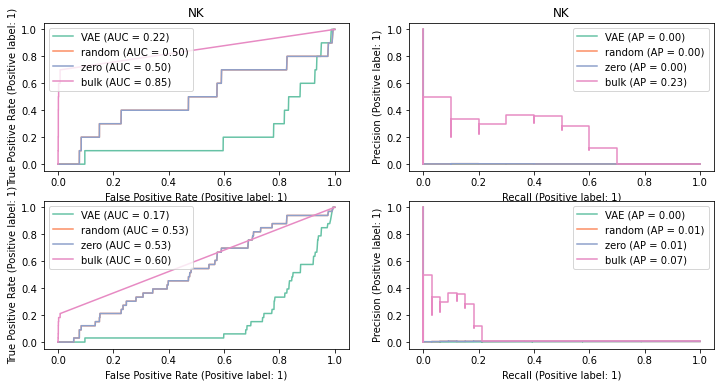

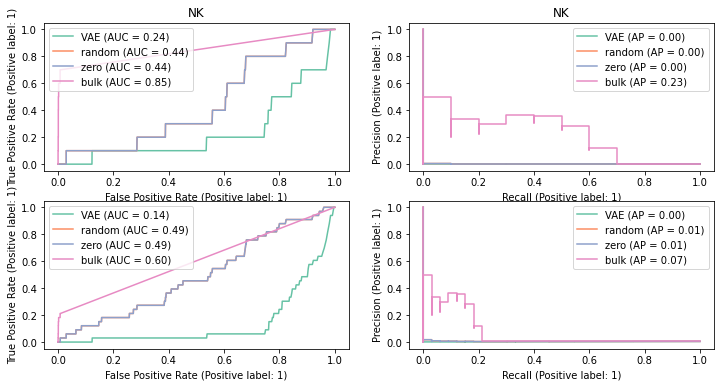

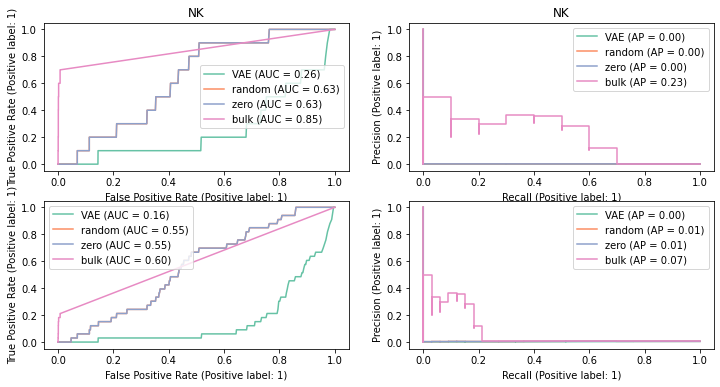

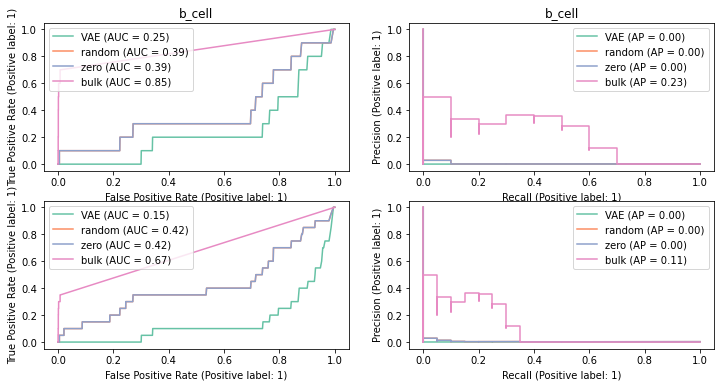

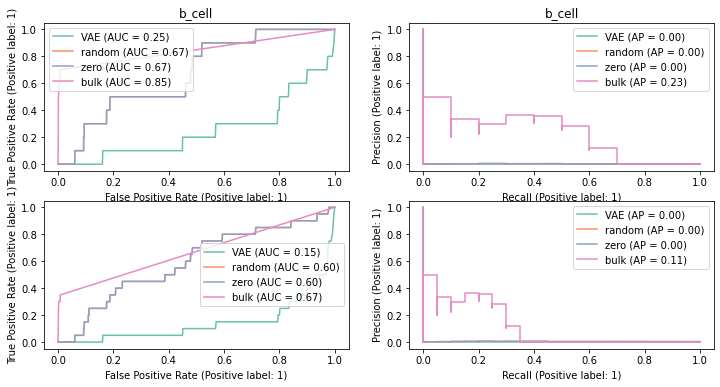

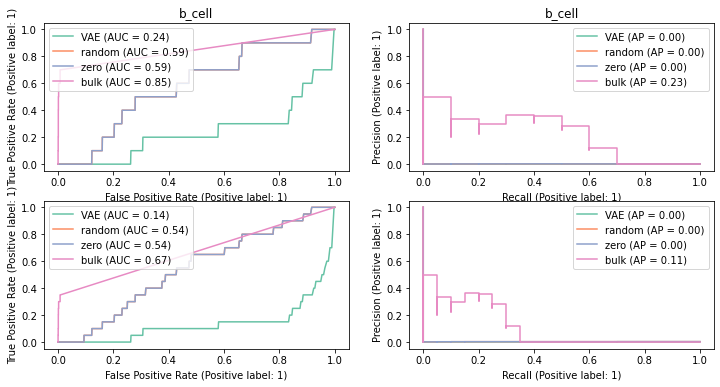

In [228]:

# get PR curve

curr_cell_type = "hepatocyte"
all_cell_types = ["hepatocyte", "hepatic_sinusoid", "kupffer",
                  "hepatic_stellate", "NK", "b_cell"]
all_DE_ref = [Pub_DE_hsc, Pub_DE_hepatic, Pub_DE_kupffer, 
              Pub_DE_hsc, Pub_DE_immune, Pub_DE_immune]


all_res_df = None
curr_idx = 0
for curr_cell_type in all_cell_types:

    print(curr_cell_type)

    # get our DE genes
    de_genes_curr = de_genes[curr_cell_type]
    if de_genes_curr is not None:
        de_genes_curr = [x.upper() for x in de_genes_curr]


    # get bulk DE genes

    # set the reference genes
    DE_ref = Pub_DE
    ct_DE_ref = all_DE_ref[curr_idx]
    extra_ref = ct_DE_ref
    if de_genes_curr is not None:
        extra_ref = np.union1d(de_genes_curr[:min_overlap], ct_DE_ref)


    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs, proj_log2FC_df, res_df = vp.plot_PR_ROC_liver(res1_meta_df, res1_decoded_0_0, res1_decoded_0_1, 
                                        bulk_sig_df, curr_cell_type, ct_DE_ref, extra_ref, 
                                        axs, union_genes_cap, method_name="VAE")

    res_df["run_id"] = 1
    all_res_df = pd.concat([all_res_df, res_df])
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs, proj_log2FC_df, res_df = vp.plot_PR_ROC_liver(res2_meta_df, res2_decoded_0_0, res2_decoded_0_1, 
                                        bulk_sig_df, curr_cell_type, ct_DE_ref, extra_ref, 
                                        axs, union_genes_cap, method_name="VAE")

    res_df["run_id"] = 2
    all_res_df = pd.concat([all_res_df, res_df])
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs, proj_log2FC_df, res_df = vp.plot_PR_ROC_liver(res3_meta_df, res3_decoded_0_0, res3_decoded_0_1, 
                                        bulk_sig_df, curr_cell_type, ct_DE_ref, extra_ref, 
                                        axs, union_genes_cap, method_name="VAE")

    res_df["run_id"] = 3
    all_res_df = pd.concat([all_res_df, res_df])
    

    curr_idx = curr_idx + 1


### plot summary of DE results

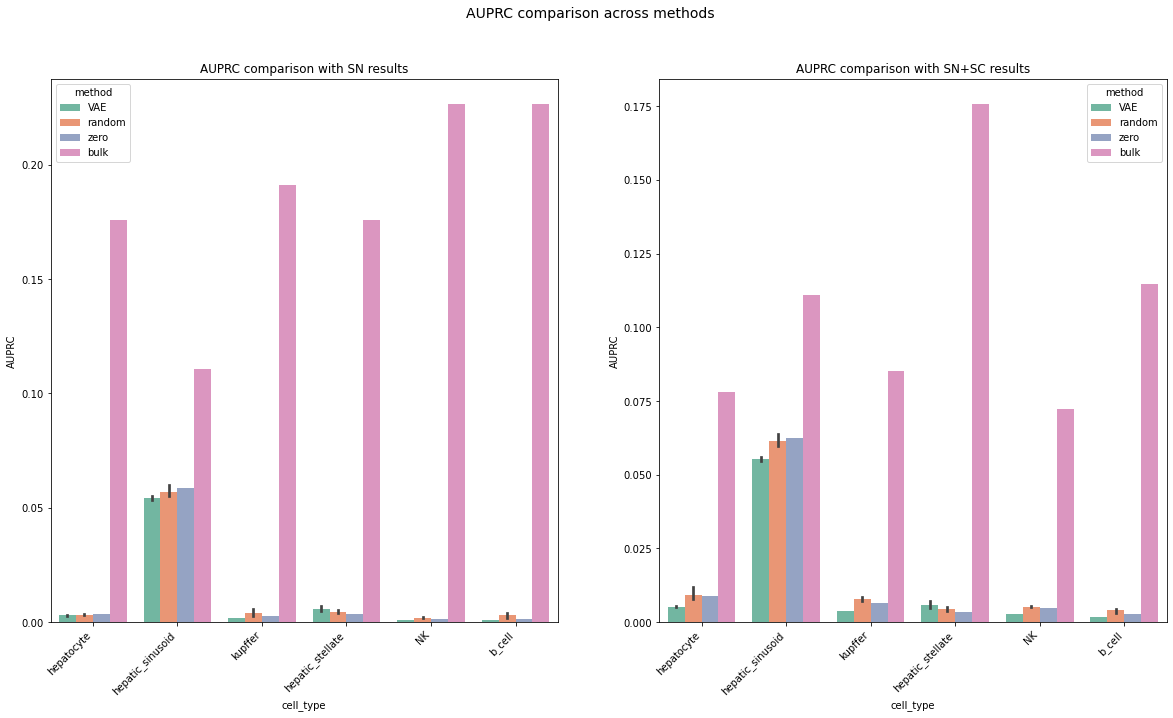

In [229]:

# plot
fig, axs = plt.subplots(1, 2, figsize=(20,10))

sns.barplot(data=all_res_df[all_res_df["ref_set"] == "sn"], 
            x="cell_type", y="scores",
            hue="method", ax= axs[0])
axs[0].set_title("AUPRC comparison with SN results")
axs[0].set(ylabel="AUPRC")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')


sns.barplot(data=all_res_df[all_res_df["ref_set"] == "sc_sn"], 
            x="cell_type", y="scores",
            hue="method", ax= axs[1])
axs[1].set_title("AUPRC comparison with SN+SC results")
axs[1].set(ylabel="AUPRC")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')


fig.suptitle("AUPRC comparison across methods", fontsize=14)

fig.show()



### write out results table

In [230]:
out_res_path = Path(f"{res_data_path}/VAE_auprc.csv")  

all_res_df.to_csv(out_res_path)  